<a href="https://colab.research.google.com/github/aslla77/practice-Python/blob/main/2nd/23_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#전이 학습(Transfer Learning)
- 학습데이터의 부족
  - CNN모델의 품질을 높이기위해서는, 즉 임의의 데이터에 대해서 정확도는 높이고 오버피팅은 줄이기 위해서는 기본적으로 많은 양의 데이터를 이용하여 학습하여야함
  - 하지만 많은 학습 데이터를 확보하려면 많은 비용과 시간이 소요되므로 현실적으로 어렵고 쉽지 않은데 이를 해결하기 위해 등장한 것

- 전이 학습 개념 및 필요성
  - 전이학습이란 아주큰 데이터셋 21,841부류에 대해서 1419만7122장의 이미지로 구성되어 있는 ImageNet데이터를 사용해서 학습된 모델의 가중치를 가져와서, 우리가 해결하려는 문제에 맞게 보정해서 사용하는 것을 의미함

  - 이때 큰 데이터 셋을 사용해서 훈련된 모델을 사전 학습 모델(pre-trained model)이라고 함

####풍부한 데이터로 사전 학습모델로 전이 학습을 하여 새로운 사용자 데이터에 맞게 가중치를 업데이트하여 사용하는 것이 전이 학습

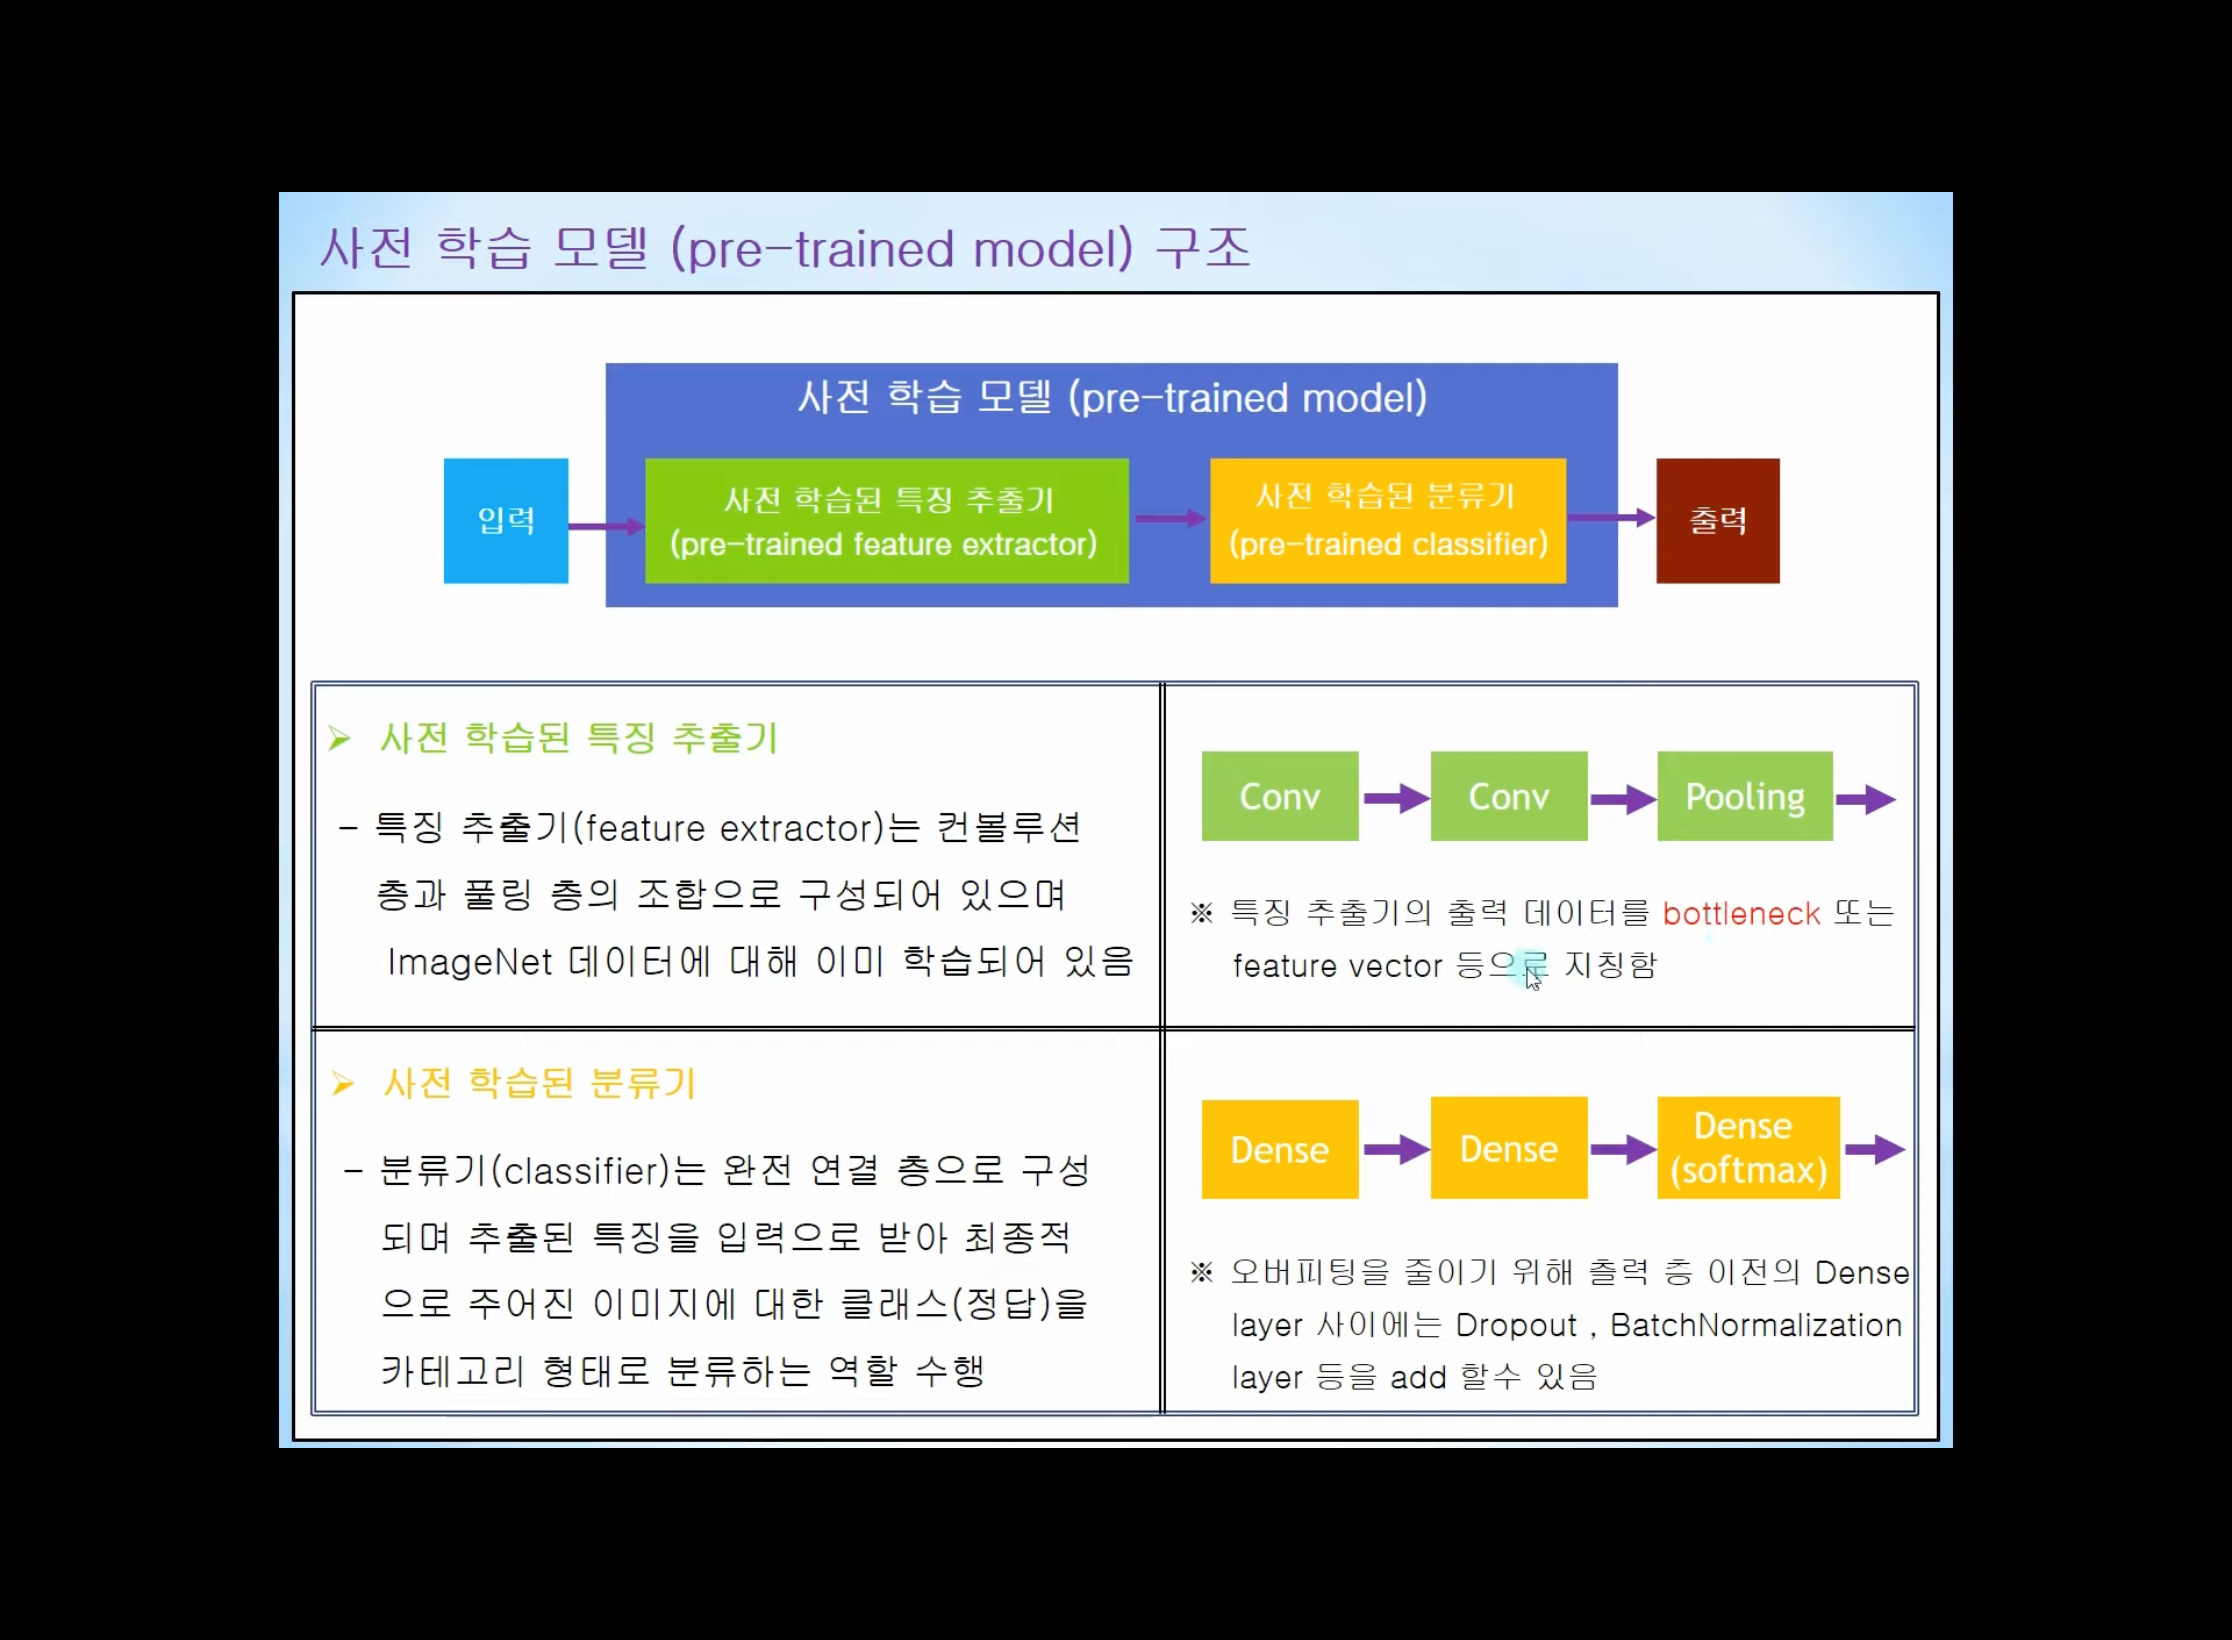

#파인 튜닝(fine-tuning)
- 사전에 학습된 특징추출기에 새로운 데이터를 넣고
- 새로운 분류기를 넣어서 분류기와 특징 추출기를 전체적으로 새로 만들거나 부분만 조정이 가능하다
- 전체적으로 조정 할때는 learning_rate를 매우 낮게 한다

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
#사전에 학습된 모델을 import시킨다
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3


In [2]:
#weights= : 사전학습에 사용된 데이터셋
#include_top=False : 사전학습모델의 특징 추출기만 가져옴
#include_top=True  : 사전학습모델의 특징 추출기와 분류기 모두 가져옴
#input_shape= :새롭게 학습 시킬 이미지 텐서의 크기

base_model=VGG16(weights='imagenet',include_top=False,input_shape=(240,240,3))

base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                              

In [3]:
model=Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 16,320,644
Trainable params: 16,320,644
Non-trainable params: 0
_________________________________________________________________


#Training data
- cats and dogs
  - CNN 아키텍처를 구축하고 평가하기 위한 일종의 Hello World와 같은 학습데이터
  - 2000개의 학습 데이터와 1000개의 테스트 데이터로 이루어져 있음
    - CIFAR10의 데이터에 비하면 매우 모자르기에 전이학습이 매우 중요해짐

In [4]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
#파일 다운로드
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-08-16 15:58:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  99.4MB/s    in 0.7s    

2022-08-16 15:58:50 (99.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [7]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/')

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

base_model=Xception(weights='imagenet',include_top=False,input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2,activation='softmax'))

model.summary()

83697664/83683744 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
N

In [9]:
train_dir='/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir='/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_data_gen=ImageDataGenerator(rescale=1./255., #이미지정규화
                                  rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.1,zoom_range=0.1)
test_data_gen=ImageDataGenerator(rescale=1./255.)

In [10]:
train_data=train_data_gen.flow_from_directory(train_dir,batch_size=32,
                                              color_mode='rgb', shuffle=True,class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))
test_data=test_data_gen.flow_from_directory(test_dir,batch_size=32,
                                              color_mode='rgb', shuffle=True,class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))
#모드에서 원핫 인코딩읋 해주었다

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(2e-5),metrics=['accuracy'])
#학습률을 낮게 설정

In [13]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

savefile='./cats_and_dogs_filltered_Xception_Colab.h5'

checkpoint=ModelCheckpoint(savefile,monitor='val_loss',
                           verbose=1, save_best_only=True,mode='auto')
earlystoping=EarlyStopping(monitor='val_loss',patience=5)

hist=model.fit(train_data,epochs=30,validation_data=test_data,callbacks=[checkpoint,earlystoping])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8435
Epoch 1: val_loss improved from inf to 0.12467, saving model to ./cats_and_dogs_filltered_Xception_Colab.h5
63/63 [==============================] - 65s 726ms/step - loss: 0.4467 - accuracy: 0.8435 - val_loss: 0.1247 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9590
Epoch 2: val_loss improved from 0.12467 to 0.05530, saving model to ./cats_and_dogs_filltered_Xception_Colab.h5
63/63 [==============================] - 43s 677ms/step - loss: 0.1843 - accuracy: 0.9590 - val_loss: 0.0553 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9760
Epoch 3: val_loss improved from 0.05530 to 0.04489, saving model to ./cats_and_dogs_filltered_Xception_Colab.h5
63/63 [==============================] - 46s 732ms/step - loss: 0.1050 - accuracy: 0.9760 - val_loss: 0.0449 - val_accurac

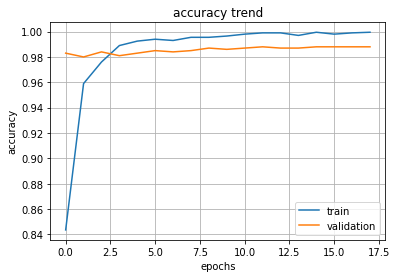

In [14]:
plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

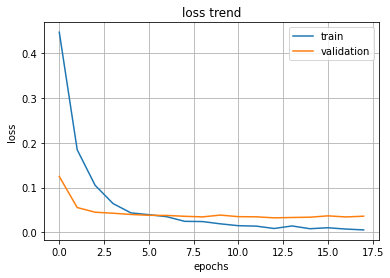

In [15]:
plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()